In [1]:
from plots.mpltoolkit import named_colors, mpl_loc, markers, fancy_legend, load_style_sheet
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter as fsf
from scipy.stats import linregress
import numpy as np
import random
import vice
import sys
sys.path.append("..")
from src.stats import skewnormal_mode_sample, jackknife_summary_statistic
load_style_sheet("papers")
# load_mpl_presets()
# mpl.rcParams["axes.linewidth"] = 0.5
# mpl.rcParams["figure.titlesize"] = 14
# mpl.rcParams["axes.titlesize"] = 14
# mpl.rcParams["axes.labelsize"] = 14
# mpl.rcParams["xtick.labelsize"] = 14
# mpl.rcParams["ytick.labelsize"] = 14
# mpl.rcParams["legend.fontsize"] = 14
print(sys.version_info)

/Users/jamesjohnson/Work/Research/lib/public-dev/VICE/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


sys.version_info(major=3, minor=12, micro=3, releaselevel='final', serial=0)


In [2]:
output = "../outputs/outerburst/eta-eR/yieldsolar2"
output = vice.output(output)

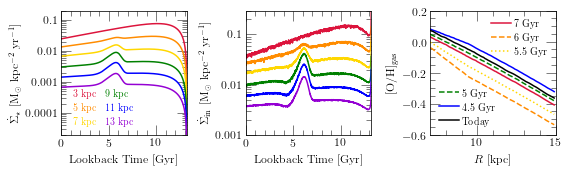

In [4]:
RADII = [3, 5, 7, 9, 11, 13]
RADII_COLORS = ["crimson", "darkorange", "gold", "green", "blue", "darkviolet"]
LOOKBACKS = [7, 6, 5.5, 5, 4.5, 0]
LOOKBACKS_COLORS = ["crimson", "darkorange", "gold", "green", "blue", "black"]
LOOKBACKS_LINESTYLES = ["-", "--", ":", "--", "-", "-"]
ZONE_WIDTH = 0.1

fig = plt.figure(figsize = (8, 2.5))
axes = []
for i in range(3): axes.append(fig.add_subplot(131 + i))
axes[0].set_xlabel(r"Lookback Time [Gyr]")
axes[0].set_ylabel(r"$\dot{\Sigma}_\star$ [M$_\odot$ kpc$^{-2}$ yr$^{-1}$]")
axes[0].set_xlim([0, 13.2])
axes[0].set_ylim([2e-5, 0.2])
axes[0].set_yscale("log")
axes[0].yaxis.set_major_formatter(fsf("%g"))
axes[1].set_xlabel(r"Lookback Time [Gyr]")
axes[1].set_ylabel(r"$\dot{\Sigma}_\text{in}$ [M$_\odot$ kpc$^{-2}$ yr$^{-1}$]")
axes[1].set_xlim([0, 13.2])
axes[1].set_ylim([1e-3, 0.3])
axes[1].set_yscale("log")
axes[1].yaxis.set_major_formatter(fsf("%g"))
axes[2].set_xlabel(r"$R$ [kpc]")
axes[2].set_ylabel(r"[O/H]$_\text{gas}$")
axes[2].set_xlim([7, 15])
axes[2].set_ylim([-0.6, 0.2])

def plot_sfh(ax, output, radius, **kwargs):
    zone = int(radius / ZONE_WIDTH)
    zone = output.zones["zone%d" % (zone)]
    area = np.pi * ((radius + ZONE_WIDTH)**2 - radius**2)
    sfh = [s / area for s in zone.history["sfr"]]
    return ax.plot(zone.history["lookback"], sfh, **kwargs)

def plot_ifh(ax, output, radius, **kwargs):
    zone = int(radius / ZONE_WIDTH)
    zone = output.zones["zone%d" % (zone)]
    area = np.pi * ((radius + ZONE_WIDTH)**2 - radius**2)
    ifh = [i / area for i in zone.history["ifr"]]
    return ax.plot(zone.history["lookback"], ifh, **kwargs)

def plot_gradient_snapshot(ax, output, lookback, element = "o", **kwargs):
    radii = np.arange(ax.get_xlim()[0], ax.get_xlim()[1], ZONE_WIDTH)
    diff = [abs(_ - lookback) for _ in output.zones["zone0"].history["lookback"]]
    idx = diff.index(min(diff))
    xh = []
    base = int(radii[0] / ZONE_WIDTH)
    for i in range(len(radii)): xh.append(
        output.zones["zone%d" % (i + base)].history["[%s/h]" % (element)][idx])
    return ax.plot(radii, xh, **kwargs)

for i in range(len(RADII)):
    kwargs = {
        "c": named_colors()[RADII_COLORS[i]],
        "label": r"$%d$ kpc" % (RADII[i])
    }
    plot_sfh(axes[0], output, RADII[i], **kwargs)
    plot_ifh(axes[1], output, RADII[i], **kwargs)

handles = []
labels = []
for i in range(len(LOOKBACKS)):
    kwargs = {
        "c": named_colors()[LOOKBACKS_COLORS[i]],
        "linestyle": LOOKBACKS_LINESTYLES[i]
    }
    if LOOKBACKS[i]:
        labels.append(r"$%g$ Gyr" % (LOOKBACKS[i]))
    else:
        # kwargs["linewidth"] = 2
        labels.append("Today")
    handles.append(plot_gradient_snapshot(axes[2], output, LOOKBACKS[i], **kwargs)[0])

legend_break = 3
kwargs = {
    "loc": mpl_loc("upper right"),
    # "bbox_to_anchor": (0.99, 0.99),
    "ncol": 1,
    "handlelength": 2,
    "fontsize": 10
}
leg = axes[2].legend(handles[:legend_break], labels[:legend_break], **kwargs)
# fancy_legend(leg, LOOKBACKS_COLORS[:legend_break])
axes[2].add_artist(leg)
kwargs["loc"] = mpl_loc("lower left")
# kwargs["bbox_to_anchor"] = (0.01, 0.01)
leg = axes[2].legend(handles[legend_break:], labels[legend_break:], **kwargs)
# fancy_legend(leg, LOOKBACKS_COLORS[legend_break:])

kwargs = {
    "loc": mpl_loc("lower left"),
    "ncol": 2,
    "handlelength": 0,
    "columnspacing": 0.5,
    "fontsize": 10
}
leg = axes[0].legend(**kwargs)
fancy_legend(leg, RADII_COLORS)

plt.tight_layout()
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("./perturbative/outerburst-evol.%s" % (ext), **kwargs)
plt.show()

/var/folders/26/nqb98q9x5_q6brmqy4v21dqm0000gp/T/ipykernel_62131/2081774497.py:109: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


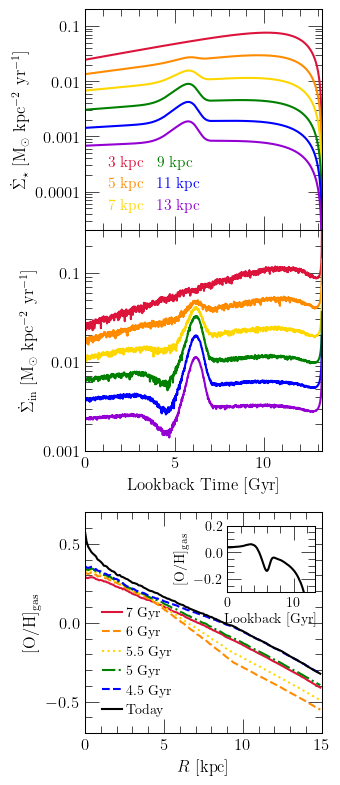

In [9]:
RADII = [3, 5, 7, 9, 11, 13]
RADII_COLORS = ["crimson", "darkorange", "gold", "green", "blue", "darkviolet"]
LOOKBACKS = [7, 6, 5.5, 5, 4.5, 0]
LOOKBACKS_COLORS = ["crimson", "darkorange", "gold", "green", "blue", "black"]
LOOKBACKS_LINESTYLES = ["-", "--", ":", "-.", "--", "-"]
ZONE_WIDTH = 0.1
INSET_WIDTH = 0.25

fig = plt.figure(figsize = (3.5, 8))
axes = []
for i in range(3): axes.append(fig.add_subplot(311 + i))
# axes[0].set_xlabel(r"Lookback Time [Gyr]")
plt.setp(axes[0].get_xticklabels(), visible = False)
axes[0].set_ylabel(r"$\dot{\Sigma}_\star$ [M$_\odot$ kpc$^{-2}$ yr$^{-1}$]")
axes[0].set_xlim([0, 13.2])
axes[0].set_ylim([2e-5, 0.2])
axes[0].set_yscale("log")
axes[0].yaxis.set_major_formatter(fsf("%g"))
axes[1].set_xlabel(r"Lookback Time [Gyr]")
axes[1].set_ylabel(r"$\dot{\Sigma}_\text{in}$ [M$_\odot$ kpc$^{-2}$ yr$^{-1}$]")
axes[1].set_xlim([0, 13.2])
axes[1].set_ylim([1e-3, 0.3])
axes[1].set_yscale("log")
axes[1].yaxis.set_major_formatter(fsf("%g"))
axes[2].set_xlabel(r"$R$ [kpc]")
axes[2].set_ylabel(r"[O/H]$_\text{gas}$")
axes[2].set_xlim([0, 15])
axes[2].set_ylim([-0.7, 0.7])
axes[2].set_yticks([-0.5, 0, 0.5])
inset = fig.add_axes([0.1, 0.1, 0.1, 0.1])
inset.set_xlabel(r"Lookback [Gyr]", fontsize = 10, labelpad = 2)
inset.set_ylabel(r"[O/H]$_\text{gas}$", fontsize = 10)
inset.set_xlim([0, 13.2])
inset.set_ylim([-0.3, 0.2])
inset.set_yticks([-0.2, 0, 0.2])
inset.tick_params(axis = "both", labelsize = 10)

def plot_sfh(ax, output, radius, **kwargs):
    zone = int(radius / ZONE_WIDTH)
    zone = output.zones["zone%d" % (zone)]
    area = np.pi * ((radius + ZONE_WIDTH)**2 - radius**2)
    sfh = [s / area for s in zone.history["sfr"]]
    return ax.plot(zone.history["lookback"], sfh, **kwargs)

def plot_ifh(ax, output, radius, **kwargs):
    zone = int(radius / ZONE_WIDTH)
    zone = output.zones["zone%d" % (zone)]
    area = np.pi * ((radius + ZONE_WIDTH)**2 - radius**2)
    ifh = [i / area for i in zone.history["ifr"]]
    return ax.plot(zone.history["lookback"], ifh, **kwargs)

def plot_gradient_snapshot(ax, output, lookback, element = "o", **kwargs):
    radii = np.arange(ax.get_xlim()[0], ax.get_xlim()[1], ZONE_WIDTH)
    diff = [abs(_ - lookback) for _ in output.zones["zone0"].history["lookback"]]
    idx = diff.index(min(diff))
    xh = []
    base = int(radii[0] / ZONE_WIDTH)
    for i in range(len(radii)): xh.append(
        output.zones["zone%d" % (i + base)].history["[%s/h]" % (element)][idx])
    return ax.plot(radii, xh, **kwargs)

def plot_oh_solar_annulus(ax, output, rsun = 8, **kwargs):
    zone = int(rsun / ZONE_WIDTH)
    zone = output.zones["zone%d" % (zone)]
    # return ax.plot(zone.history["time"], zone.history["[o/h]"], **kwargs)
    return ax.plot(zone.history["lookback"], zone.history["[o/h]"], **kwargs)

for i in range(len(RADII)):
    kwargs = {
        "c": named_colors()[RADII_COLORS[i]],
        "label": r"$%d$ kpc" % (RADII[i])
    }
    plot_sfh(axes[0], output, RADII[i], **kwargs)
    plot_ifh(axes[1], output, RADII[i], **kwargs)
    
for i in range(len(LOOKBACKS)):
    kwargs = {
        "c": named_colors()[LOOKBACKS_COLORS[i]],
        "linestyle": LOOKBACKS_LINESTYLES[i]
    }
    if LOOKBACKS[i]:
        kwargs["label"] = "%g Gyr" % (LOOKBACKS[i])
    else:
        kwargs["label"] = "Today"
    plot_gradient_snapshot(axes[2], output, LOOKBACKS[i], **kwargs)
plot_oh_solar_annulus(inset, output, c = named_colors()["black"])

kwargs = {
    "loc": mpl_loc("lower left"),
    "bbox_to_anchor": (0.02, 0.02),
    "ncol": 2,
    "handlelength": 0,
    "fontsize": 11,
    "columnspacing": 0.5
}
leg = axes[0].legend(**kwargs)
fancy_legend(leg, RADII_COLORS)
    
kwargs = {
    "loc": mpl_loc("lower left"),
    "bbox_to_anchor": (0.02, 0.02),
    "handlelength": 1.4,
    "fontsize": 10,
    # "ncol": 2,
    # "columnspacing": 0.5
}
axes[2].legend(**kwargs)

plt.tight_layout()
plt.subplots_adjust(bottom = 0)
shift = axes[0].get_position().y0 - axes[1].get_position().y1
for ax in axes[1:]:
    ax.set_position([
        ax.get_position().x0,
        ax.get_position().y0 + shift,
        ax.get_position().x1 - ax.get_position().x0,
        ax.get_position().y1 - ax.get_position().y0
    ])
inset.set_position([
    axes[2].get_position().x1 - 0.27,
    axes[2].get_position().y1 - 0.1,
    INSET_WIDTH,
    1/3 * INSET_WIDTH
])
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("./perturbative/outerburst-evol.%s" % (ext), **kwargs)
plt.show()

In [36]:
output = "../outputs/inside-out/eta-eR/yieldsolar3-etaevol"
output = vice.output(output)

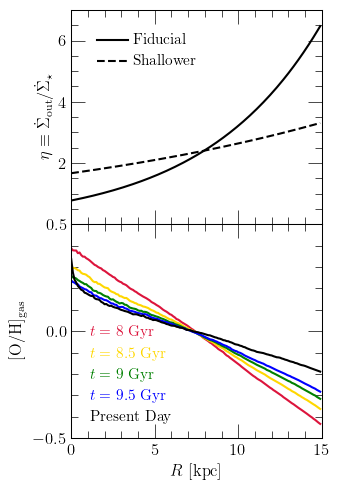

In [40]:
ELEMENT = "O"
SNAPSHOTS = [8, 8.5, 9, 9.5, 13.2]
COLORS = ["crimson", "gold", "green", "blue", "black"]
ZONE_WIDTH = 0.1

fig = plt.figure(figsize = (3.5, 5))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212, sharex = ax1)
plt.setp(ax1.get_xticklabels(), visible = False)
ax1.set_ylabel(r"$\eta \equiv \dot{\Sigma}_\text{out} / \dot{\Sigma}_\star$")
ax2.set_xlabel(r"$R$ [kpc]")
ax2.set_ylabel(r"[%s/H]$_\text{gas}$" % (ELEMENT.capitalize()))
ax1.set_xlim([0, 15])
ax1.set_ylim([0, 7])
ax1.set_yticks([2, 4, 6])
ax2.set_ylim([-0.5, 0.5])
ax2.set_yticks([-0.5, 0, 0.5])

def plot_snapshot(ax, output, time, **kwargs):
    diff = [abs(time - _) for _ in output.zones["zone0"].history["time"]]
    idx = diff.index(min(diff))
    radii = np.arange(ax.get_xlim()[0], ax.get_xlim()[1], ZONE_WIDTH)
    xh = []
    for i in range(len(radii)):
        zone = output.zones["zone%d" % (i)]
        xh.append(zone.history["[%s/h]" % (ELEMENT)][idx])
    ax.plot(radii, xh, **kwargs)

def plot_eta(ax, output, time, **kwargs):
    diff = [abs(time - _) for _ in output.zones["zone0"].history["time"]]
    idx = diff.index(min(diff))
    radii = np.arange(ax.get_xlim()[0], ax.get_xlim()[1], ZONE_WIDTH)
    eta = []
    for i in range(len(radii)):
        zone = output.zones["zone%d" % (i)]
        eta.append(zone.history["eta_0"][idx])
    ax.plot(radii, eta, **kwargs)

plot_eta(ax1, output, 5, c = named_colors()["black"], label = "Fiducial")
plot_eta(ax1, output, 10, c = named_colors()["black"], linestyle = "--", label = "Shallower")
for i in range(len(SNAPSHOTS)):
    kwargs = {"c": named_colors()[COLORS[i]]}
    if SNAPSHOTS[i] == 13.2:
        kwargs["label"] = "Present Day"
    else:
        kwargs["label"] = r"$t = %g$ Gyr" % (SNAPSHOTS[i])
    plot_snapshot(ax2, output, SNAPSHOTS[i], **kwargs)

kwargs = {
    "loc": mpl_loc("upper left"),
    "bbox_to_anchor": (0.05, 0.95),
    "fontsize": 11
}
ax1.legend(**kwargs)

kwargs = {
    "loc": mpl_loc("lower left"),
    "handlelength": 0,
    "fontsize": 11
}
leg = ax2.legend(**kwargs)
fancy_legend(leg, COLORS)

plt.tight_layout()
plt.subplots_adjust(hspace = 0)
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("./perturbative/eta-sudden-change.%s" % (ext), **kwargs)
plt.show()